### Main Project 1 script

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import fetch_20newsgroups

np.random.seed(42)
random.seed(42)

In [7]:
########################################################################################################################
## Custom Transformers for Grid Search

from sklearn.datasets import fetch_20newsgroups
from sklearn.base import BaseEstimator, TransformerMixin
import re
# The lemmatizer is actually pretty complicated, it needs Parts of Speech (POS) tags
import nltk
from nltk import pos_tag
# nltk.download('punkt')#, if you need "tokenizers/punkt/english.pickle", choose it
# nltk.download('averaged_perceptron_tagger')


class Importer(BaseEstimator, TransformerMixin):

    def __init__(self, remove=None):
        self.remove = remove

    def transform(self, raw_documents, *_):
        if self.remove is not None:
            if 'headers' in self.remove:
                raw_documents = [self.strip_newsgroup_header(text) for text in raw_documents]
            if 'footers' in self.remove:
                raw_documents = [self.strip_newsgroup_footer(text) for text in raw_documents]

        return raw_documents

    def fit(self, *_):
        return self

    ## Taken from twenty_newsgroups.py
    @staticmethod
    def strip_newsgroup_header(text):
        """
        Given text in "news" format, strip the headers, by removing everything
        before the first blank line.

        Parameters
        ----------
        text : string
            The text from which to remove the signature block.
        """
        _before, _blankline, after = text.partition('\n\n')
        return after

    _QUOTE_RE = re.compile(r'(writes in|writes:|wrote:|says:|said:'
                           r'|^In article|^Quoted from|^\||^>)')

    ## Taken from twenty_newsgroups.py
    @staticmethod
    def strip_newsgroup_footer(text):
        """
        Given text in "news" format, attempt to remove a signature block.

        As a rough heuristic, we assume that signatures are set apart by either
        a blank line or a line made of hyphens, and that it is the last such line
        in the file (disregarding blank lines at the end).

        Parameters
        ----------
        text : string
            The text from which to remove the signature block.
        """
        lines = text.strip().split('\n')
        for line_num in range(len(lines) - 1, -1, -1):
            line = lines[line_num]
            if line.strip().strip('-') == '':
                break

        if line_num > 0:
            return '\n'.join(lines[:line_num])
        else:
            return text


class Lemmatizer(BaseEstimator, TransformerMixin):

    def __init__(self, enabled=True):
        self.enabled = enabled
        self.wnl = nltk.wordnet.WordNetLemmatizer()

    def transform(self, raw_documents, *_):
        if self.enabled:
            return self._lemmatize_and_filter(raw_documents)
        else:
            return raw_documents

    def fit(self, *_):
        return self

    ##################################################################
    # supporting functions:
    def _penn2morphy(self, penntag):
        """ Converts Penn Treebank tags to WordNet. """
        morphy_tag = {'NN': 'n', 'JJ': 'a',
                      'VB': 'v', 'RB': 'r'}
        try:
            return morphy_tag[penntag[:2]]
        except:
            return 'n'

    # def lemmatize_sent(list_word, wnl):
    #     # Text input is string, returns array of lowercased strings(words).
    #     return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag))
    #             for word, tag in pos_tag(list_word)]

    def _lemmatize_training(self, text):
        # Text input is string, returns array of lowercased strings(words).
        return [self.wnl.lemmatize(word.lower(), pos=self._penn2morphy(tag))
                for word, tag in pos_tag(nltk.word_tokenize(text))]

    def _filter_numbers(self, text_array):
        # Filter out any numbers found in the array of strings
        output = []
        for s in text_array:
            if not s.isdigit():
                # if not a digit...
                try:
                    # if a float, filter out
                    float(s)
                except ValueError:
                    # if not a float, add to output
                    output.append(s)
            else:
                # if a digit, filter out
                pass
        return output

    def _array_to_string(self, text_array, delimeter=""):
        # Converts an array back into a string of words using the provided delimeter to add between each word
        output = ""
        for s in text_array:
            output = output + delimeter + s
        return output

    def _lemmatize_and_filter(self, documents):
        # Performs lemmatization, and number filtering on the given documents
        lemmatized_data = []
        for i in documents:
            # lemmatize the document:
            training_tagged = pos_tag(nltk.word_tokenize(i))
            lemmatized_array = self._lemmatize_training(i)

            # remove numbers from document:
            filtered_array = self._filter_numbers(lemmatized_array)

            # reassemble back to string:
            lemmatized_string = self._array_to_string(filtered_array, ' ')

            # add to final data list
            # print(lemmatized_string)
            lemmatized_data.append(lemmatized_string)

        return lemmatized_data

In [2]:
# categories = ['comp.graphics', 'comp.os.ms-windows.misc',
#               'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
#               'rec.autos', 'rec.motorcycles',
#               'rec.sport.baseball', 'rec.sport.hockey']
# train_dataset = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
# test_dataset = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

#### Question 1

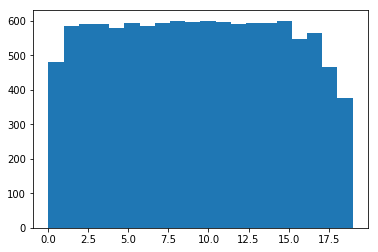

In [3]:
# Fetch all 20 news groups categories and plot a histogram of the training documents.

newsgroups_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
plt.hist(newsgroups_train.target, 20)
plt.show()

#### Question 2

In [4]:
########################################################################################################################
# Fetching 20NewsGroups dataset

categories = ['comp.graphics', 'comp.os.ms-windows.misc',
              'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
              'rec.autos', 'rec.motorcycles',
              'rec.sport.baseball', 'rec.sport.hockey']

twenty_train = fetch_20newsgroups(subset='train', # choose which subset of the dataset to use; can be 'train', 'test', 'all'
                                  categories=categories, # choose the categories to load; if is `None`, load all categories
                                  shuffle=True,
                                  random_state=42, # set the seed of random number generator when shuffling to make the outcome repeatable across different runs
                                  # remove=['headers'],
                                  )
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

# Change labels into binary based on two well separated classes: Computer (labels 0-3) and Recreational (labels 4-7).
twenty_train_binary_labels = np.zeros(len(twenty_train.target))
for k in range(len(twenty_train.target)):
    if twenty_train.target[k] >= 4:
        twenty_train_binary_labels[k] = 1
twenty_test_binary_labels = np.zeros(len(twenty_test.target))
for k in range(len(twenty_test.target)):
    if twenty_test.target[k] >= 4:
        twenty_test_binary_labels[k] = 1
        
i = 51
print(twenty_train.filenames[i])
print(twenty_train.target[i])
print(twenty_train.target_names)

C:\Users\zharr\scikit_learn_data\20news_home\20news-bydate-train\comp.sys.mac.hardware\51613
3
['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']


In [5]:
########################################################################################################################
# Perform lemmatization on dataset

# The lemmatizer is actually pretty complicated, it needs Parts of Speech (POS) tags
import nltk
from nltk import pos_tag
# nltk.download('punkt')#, if you need "tokenizers/punkt/english.pickle", choose it
# nltk.download('averaged_perceptron_tagger')

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN': 'n', 'JJ': 'a',
                  'VB': 'v', 'RB': 'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'


# def lemmatize_sent(list_word, wnl):
#     # Text input is string, returns array of lowercased strings(words).
#     return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag))
#             for word, tag in pos_tag(list_word)]


wnl = nltk.wordnet.WordNetLemmatizer()
def lemmatize_training(text):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag))
            for word, tag in pos_tag(nltk.word_tokenize(text))]


# TODO: should this filter out the following numbers too? "4-5" "c650"
def filter_numbers(text_array):
    # Filter out any numbers found in the array of strings
    output = []
    for s in text_array:
        if not s.isdigit():
            # if not a digit...
            try:
                # if a float, filter out
                float(s)
            except ValueError:
                # if not a float, add to output
                output.append(s)
        else:
            # if a digit, filter out
            pass
    return output


def array_to_string(text_array, delimeter=""):
    # Converts an array back into a string of words using the provided delimeter to add between each word
    output = ""
    for s in text_array:
        output = output + delimeter + s
    return output


def lemmatize_and_filter(documents):
    # Performs lemmatization, and number filtering on the given documents
    lemmatized_data = []
    for i in documents:
        # lemmatize the document:
        training_tagged = pos_tag(nltk.word_tokenize(i))
        lemmatized_array = lemmatize_training(i)

        # remove numbers from document:
        filtered_array = filter_numbers(lemmatized_array)

        # reassemble back to string:
        lemmatized_string = array_to_string(filtered_array, ' ')

        # add to final data list
        # print(lemmatized_string)
        lemmatized_data.append(lemmatized_string)

    return lemmatized_data


# print(lemmatized_data[0])
lemmatized_training = lemmatize_and_filter(twenty_train.data)
lemmatized_testing = lemmatize_and_filter(twenty_test.data)

In [6]:
########################################################################################################################
# Push lemmatized documents through CountVectorizer

# count_vect = CountVectorizer(min_df=3)
from sklearn.feature_extraction.text import CountVectorizer

# do for training
count_vect = CountVectorizer(min_df=3, stop_words='english')
X_lemmatized_train_counts = count_vect.fit_transform(lemmatized_training)

# do for testing
X_lemmatized_test_counts = count_vect.transform(lemmatized_testing)

In [7]:
########################################################################################################################
# Report shapes of TF-IDF matrices

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

# do for training
X_lemmatized_train_tfidf = tfidf_transformer.fit_transform(X_lemmatized_train_counts)

print(X_lemmatized_train_tfidf.shape)
print('-' * 20)
print(X_lemmatized_train_counts.toarray()[:30, :5])
print('-' * 20)
print(X_lemmatized_train_tfidf.toarray()[:30, :5])

# do for testing
X_lemmatized_test_tfidf = tfidf_transformer.transform(X_lemmatized_test_counts)

print(X_lemmatized_test_tfidf.shape)
print('-' * 20)
print(X_lemmatized_test_counts.toarray()[:30, :5])
print('-' * 20)
print(X_lemmatized_test_tfidf.toarray()[:30, :5])

(4732, 17426)
--------------------
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
--------------------
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(3150, 17426

#### Question 3

In [8]:
# Perform LSI using the truncated SVD

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50, random_state=42)
X_lsi_train_reduced = svd.fit_transform(X_lemmatized_train_tfidf)
Y_lsi_train_reduced = svd.components_
print(X_lsi_train_reduced.shape)
print(svd.components_.shape)

X_lsi_test_reduced = svd.transform(X_lemmatized_test_tfidf)
Y_lsi_test_reduced = svd.components_
print(X_lsi_train_reduced.shape)
print(svd.components_.shape)

(4732, 50)
(50, 17426)
(4732, 50)
(50, 17426)


In [9]:
# Perform NMF

from sklearn.decomposition import NMF

model = NMF(n_components=50, init='random', random_state=42)
W_nmf_train_reduced = model.fit_transform(X_lemmatized_train_tfidf)
H_nmf_train_reduced = model.components_

print(W_nmf_train_reduced.shape)
print(H_nmf_train_reduced.shape)

W_nmf_test_reduced = model.transform(X_lemmatized_test_tfidf)
H_nmf_test_reduced = model.components_

(4732, 50)
(50, 17426)


In [10]:
# Compare LSI and NMF

nmf_val = np.linalg.norm(X_lemmatized_train_tfidf - np.matmul(W_nmf_train_reduced, H_nmf_train_reduced), 'fro')**2
lsi_val = np.linalg.norm(X_lemmatized_train_tfidf - np.matmul(X_lsi_train_reduced, Y_lsi_train_reduced), 'fro')**2

print('NMF: ', nmf_val)
print('LSI: ', lsi_val)

NMF:  4156.107160867976
LSI:  4119.976000821951


## Question 4

In [11]:
# Training 2 linear SVMs

from sklearn.svm import LinearSVC

# hard margin
gamma_1 = 1000
clf_svc_1 = LinearSVC(C=gamma_1,max_iter=100000).fit(X_lsi_train_reduced, twenty_train_binary_labels)
predicted_svc_1 = clf_svc_1.predict(X_lsi_test_reduced)

# using max_iter=100000 because otherwise the hard margin classifier does not converge

#soft margin
gamma_2 = 0.0001
clf_svc_2 = LinearSVC(C=gamma_2,max_iter=100000).fit(X_lsi_train_reduced, twenty_train_binary_labels)
predicted_svc_2 = clf_svc_2.predict(X_lsi_test_reduced)

In [12]:
# Find confusion matrix, accuracy, precision-recall, and F-1 scores for the hard margin

# Confusion matrix
from sklearn.metrics import confusion_matrix

print('Confusion matrix for linear SVM hard margin: \n', confusion_matrix(twenty_test_binary_labels, predicted_svc_1))

# Accuracy
from sklearn.metrics import accuracy_score

print('Accuracy for linear SVM hard margin: ', accuracy_score(twenty_test_binary_labels, predicted_svc_1))

# Average precision-recall score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# print('Average precision-recall score:', average_precision_score(twenty_test.target, predicted))
print('Precision score for linear SVM hard margin: ', precision_score(twenty_test_binary_labels, predicted_svc_1))
print('Recall score for linear SVM hard margin: ', recall_score(twenty_test_binary_labels, predicted_svc_1))

# F-1 score
from sklearn.metrics import f1_score

print('F-1 score for linear SVM hard margin:', f1_score(twenty_test_binary_labels, predicted_svc_1))

Confusion matrix for linear SVM hard margin: 
 [[1506   54]
 [  37 1553]]
Accuracy for linear SVM hard margin:  0.9711111111111111
Precision score for linear SVM hard margin:  0.9663970130678282
Recall score for linear SVM hard margin:  0.9767295597484277
F-1 score for linear SVM hard margin: 0.9715358148263997


In [13]:
# Find confusion matrix, accuracy, precision-recall, and F-1 scores for the soft margin

# Confusion matrix
from sklearn.metrics import confusion_matrix

print('Confusion matrix for linear SVM soft margin: \n', confusion_matrix(twenty_test_binary_labels, predicted_svc_2))

# Accuracy
from sklearn.metrics import accuracy_score

print('Accuracy for linear SVM soft margin: ', accuracy_score(twenty_test_binary_labels, predicted_svc_2))

# Average precision-recall score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# print('Average precision-recall score:', average_precision_score(twenty_test.target, predicted))
print('Precision score for linear SVM soft margin: ', precision_score(twenty_test_binary_labels, predicted_svc_2))
print('Recall score for linear SVM soft margin: ', recall_score(twenty_test_binary_labels, predicted_svc_2))

# F-1 score
from sklearn.metrics import f1_score

print('F-1 score for linear SVM soft margin:', f1_score(twenty_test_binary_labels, predicted_svc_2))

Confusion matrix for linear SVM soft margin: 
 [[ 515 1045]
 [   0 1590]]
Accuracy for linear SVM soft margin:  0.6682539682539682
Precision score for linear SVM soft margin:  0.603415559772296
Recall score for linear SVM soft margin:  1.0
F-1 score for linear SVM soft margin: 0.752662721893491


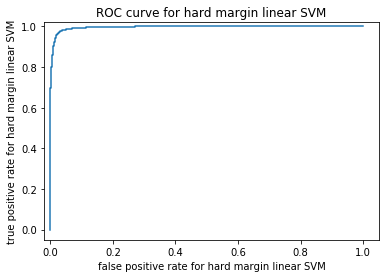

In [14]:
# ROC curve for hard margin SVM

from sklearn.metrics import roc_curve

score_svc_1 = clf_svc_1.decision_function(X_lsi_test_reduced)
fpr_svc_1, tpr_svc_1, thresholds_svc_1 = roc_curve(twenty_test_binary_labels, score_svc_1)

plt.figure()
plt.plot(fpr_svc_1, tpr_svc_1)
plt.title('ROC curve for hard margin linear SVM')
plt.xlabel('false positive rate for hard margin linear SVM')
plt.ylabel('true positive rate for hard margin linear SVM')
plt.xlim(left=-0.02)
plt.ylim(top=1.02)
plt.show()

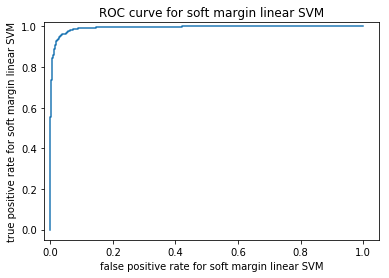

In [15]:
# ROC curve for soft margin SVM

from sklearn.metrics import roc_curve

score_svc_2 = clf_svc_2.decision_function(X_lsi_test_reduced)
fpr_svc_2, tpr_svc_2, thresholds_svc_2 = roc_curve(twenty_test_binary_labels, score_svc_2)

plt.figure()
plt.plot(fpr_svc_2, tpr_svc_2)
plt.title('ROC curve for soft margin linear SVM')
plt.xlabel('false positive rate for soft margin linear SVM')
plt.ylabel('true positive rate for soft margin linear SVM')
plt.xlim(left=-0.02)
plt.ylim(top=1.02)
plt.show()

 **Hard Margin SVM is better because accuracy for hard margin is 97% whereas it is 66% for soft margin**

In [16]:
# Cross validation to choose best gamma for the Linear SVM
import statistics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

# Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

# Set the parameters to be determined by cross-validation
tuned_parameters = {'C': [0.001, 0.01, 0.1 , 1, 10, 100, 1000]}

# We are using the F1 score to determine the best value of gamma (C) for the linear SVM classifier

clf_svc_cv = GridSearchCV(SVC(kernel='linear'), tuned_parameters, cv=5, scoring= 'f1_macro')
clf_svc_cv.fit(X_lsi_train_reduced, twenty_train_binary_labels)

print("Best value of C: ")
print()
print(clf_svc_cv.best_params_)
print()
print("Grid scores: ")
print()
means = clf_svc_cv.cv_results_['mean_test_score']
stds = clf_svc_cv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_svc_cv.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted 

Best value of C: 

{'C': 1000}

Grid scores: 

0.335 (+/-0.000) for {'C': 0.001}
0.336 (+/-0.002) for {'C': 0.01}
0.966 (+/-0.008) for {'C': 0.1}
0.971 (+/-0.008) for {'C': 1}
0.974 (+/-0.007) for {'C': 10}
0.974 (+/-0.006) for {'C': 100}
0.974 (+/-0.007) for {'C': 1000}



**Plotting the ROC curve and report the confusion matrix and calculate the
accuracy, recall precision and F-1 score of this best SVM**

In [17]:
# Find confusion matrix, accuracy, precision-recall, and F-1 scores for the best linear SVM classifier

# Confusion matrix
from sklearn.metrics import confusion_matrix

print('Confusion matrix for the best linear SVM classifier: \n', confusion_matrix(twenty_test_binary_labels, predicted_svc_1))

# Accuracy
from sklearn.metrics import accuracy_score

print('Accuracy for the best linear SVM classifier: ', accuracy_score(twenty_test_binary_labels, predicted_svc_1))

# Average precision-recall score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# print('Average precision-recall score:', average_precision_score(twenty_test.target, predicted))
print('Precision score for the best linear SVM classifier: ', precision_score(twenty_test_binary_labels, predicted_svc_1))
print('Recall score for the best linear SVM classifier: ', recall_score(twenty_test_binary_labels, predicted_svc_1))

# F-1 score
from sklearn.metrics import f1_score

print('F-1 score for the best linear SVM classifier:', f1_score(twenty_test_binary_labels, predicted_svc_1))

Confusion matrix for the best linear SVM classifier: 
 [[1506   54]
 [  37 1553]]
Accuracy for the best linear SVM classifier:  0.9711111111111111
Precision score for the best linear SVM classifier:  0.9663970130678282
Recall score for the best linear SVM classifier:  0.9767295597484277
F-1 score for the best linear SVM classifier: 0.9715358148263997


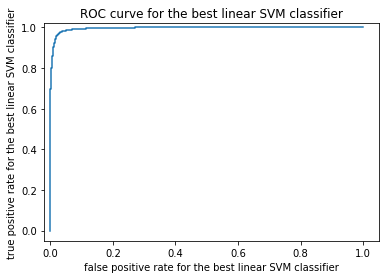

In [18]:
# ROC curve for the best linear SVM classifier

from sklearn.metrics import roc_curve

score_svc_1 = clf_svc_1.decision_function(X_lsi_test_reduced)
fpr_svc_1, tpr_svc_1, thresholds_svc_1 = roc_curve(twenty_test_binary_labels, score_svc_1)

plt.figure()
plt.plot(fpr_svc_1, tpr_svc_1)
plt.title('ROC curve for the best linear SVM classifier')
plt.xlabel('false positive rate for the best linear SVM classifier')
plt.ylabel('true positive rate for the best linear SVM classifier')
plt.xlim(left=-0.02)
plt.ylim(top=1.02)
plt.show()

#### Question 5

In [19]:
# Train an unregularized logistic regression classifier.

from sklearn.linear_model import LogisticRegression

# To be unregularized, we make the inverse of the regularization strength C 
# to be large to approximate an unregularized classifier.
clf = LogisticRegression(random_state=42, C=500, max_iter=100, solver='lbfgs').fit(X_lsi_train_reduced, twenty_train_binary_labels)

# score = clf.decision_function(X_lsi_test_reduced)
predicted = clf.predict(X_lsi_test_reduced)

In [20]:
# Find confusion matrix, accuracy, precision-recall, and F-1 scores

# Confusion matrix
from sklearn.metrics import confusion_matrix

print('Confusion matrix: \n', confusion_matrix(twenty_test_binary_labels, predicted))

# Accuracy
from sklearn.metrics import accuracy_score

print('Accuracy: ', accuracy_score(twenty_test_binary_labels, predicted))

# Average precision-recall score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# print('Average precision-recall score:', average_precision_score(twenty_test.target, predicted))
print('Precision score: ', precision_score(twenty_test_binary_labels, predicted))
print('Recall score: ', recall_score(twenty_test_binary_labels, predicted))

# F-1 score
from sklearn.metrics import f1_score

print('F-1 score:', f1_score(twenty_test_binary_labels, predicted))

Confusion matrix: 
 [[1508   52]
 [  35 1555]]
Accuracy:  0.9723809523809523
Precision score:  0.9676415681393902
Recall score:  0.9779874213836478
F-1 score: 0.9727869878010635


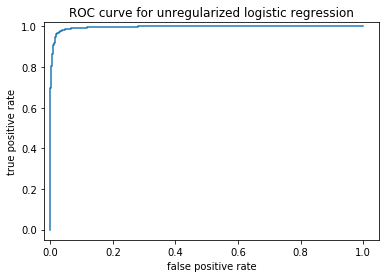

In [21]:
# ROC curve

from sklearn.metrics import roc_curve

score = clf.decision_function(X_lsi_test_reduced)
fpr, tpr, thresholds = roc_curve(twenty_test_binary_labels, score)

plt.figure()
plt.plot(fpr, tpr)
plt.title('ROC curve for unregularized logistic regression')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(left=-0.02)
plt.ylim(top=1.02)
plt.show()

Optimal regularization strength for L1 Regulation:  [0.1]
Accuracy with L1 Regulation for L1 Regulation:  0.973015873015873
Average precision-recall score for L1 Regulation: 0.957519138728885
Precision score for L1 Regulation:  0.9665220086794792
Recall score for L1 Regulation:  0.980503144654088
F-1 score for L1 Regulation: 0.9734623790196691


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1917: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


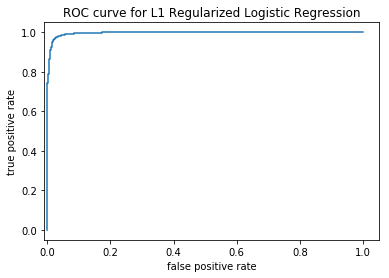


Optimal regularization strength for L2 regulation:  [0.01]
Accuracy with L2 Regulation:  0.9733333333333334
Average precision-recall score for L2 Regulation: 0.9581070282257136
Precision score for L2 Regulation:  0.96712158808933
Recall score for L2 Regulation:  0.980503144654088
F-1 score for L2 Regulation: 0.9737663960024984


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1917: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


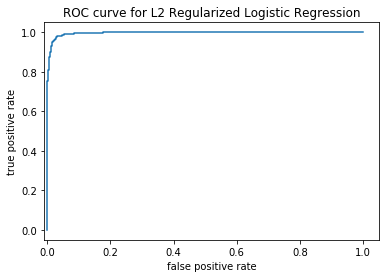

In [22]:
from sklearn.linear_model import LogisticRegressionCV

# Define training and testing data sets
X_train = X_lsi_train_reduced
y_train = twenty_train_binary_labels

X_test = X_lsi_test_reduced
y_test = twenty_test_binary_labels

# Define regularization strength values here
REG_STRENGTH_OPTIONS = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Determine regulation strength for L1 regulation
clf_L1 = LogisticRegressionCV(random_state=42, Cs=REG_STRENGTH_OPTIONS, cv=5, penalty='l1', scoring='accuracy', solver = 'liblinear').fit(X_train, y_train)
l1_reg_strength = 1/clf_L1.C_ # Regulization strength is inverse of optimal Cs
predicted_L1 = clf_L1.predict(X_test)

# Display L1 Stats
print('Optimal regularization strength for L1 Regulation: ', l1_reg_strength)
print('Accuracy with L1 Regulation for L1 Regulation: ', clf_L1.score(X_test, y_test))
print('Average precision-recall score for L1 Regulation:', average_precision_score(y_test, predicted_L1))
print('Precision score for L1 Regulation: ', precision_score(y_test, predicted_L1))
print('Recall score for L1 Regulation: ', recall_score(y_test, predicted_L1))
print('F-1 score for L1 Regulation:', f1_score(y_test, predicted_L1))

# L1 ROC Curve
score_L1 = clf_L1.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, score_L1)

plt.figure()
plt.plot(fpr, tpr)
plt.title('ROC curve for L1 Regularized Logistic Regression')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(left=-0.01)
plt.show()

# Determine regulation strength for L2 regulation
clf_L2 = LogisticRegressionCV(random_state=42, Cs=REG_STRENGTH_OPTIONS, cv=5, penalty='l2', scoring='accuracy', solver = 'liblinear').fit(X_train, y_train)
L2_reg_strength = 1/clf_L2.C_ # Regulization strength is inverse of optimal Cs
predicted_L2 = clf_L2.predict(X_test)

# Display L2 Stats
print('\nOptimal regularization strength for L2 regulation: ', L2_reg_strength)
print('Accuracy with L2 Regulation: ', clf_L2.score(X_test, y_test))
print('Average precision-recall score for L2 Regulation:', average_precision_score(y_test, predicted_L2))
print('Precision score for L2 Regulation: ', precision_score(y_test, predicted_L2))
print('Recall score for L2 Regulation: ', recall_score(y_test, predicted_L2))
print('F-1 score for L2 Regulation:', f1_score(y_test, predicted_L2))

# L2 ROC Curve
score_L2 = clf_L2.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, score_L2)

plt.figure()
plt.plot(fpr, tpr)
plt.title('ROC curve for L2 Regularized Logistic Regression')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(left=-0.01)
plt.show()

#### Question 6

In [23]:
########################################################################################################################
# Train a Naive Bayes Gaussian classifier on the reduced TFIDF training set from problem 3

from sklearn.naive_bayes import GaussianNB

Accuracy for Gaussian NB from LSI:  0.8974603174603175
Average precision-recall score for Gaussian NB from LSI: 0.8368804639741867
Precision score for Gaussian NB from LSI:  0.8452316076294278
Recall score for Gaussian NB from LSI:  0.9754716981132076
F-1 score for Gaussian NB from LSI: 0.9056934306569343


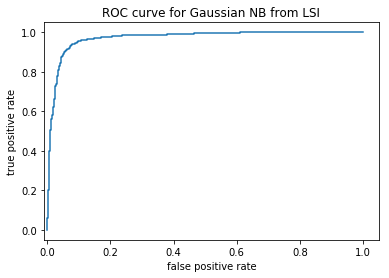

In [24]:
########################################################################################################################
# Generate stats for GaussianNB using LSI for reduction

# Define training and testing data sets
X_train = X_lsi_train_reduced
y_train = twenty_train_binary_labels

X_test = X_lsi_test_reduced
y_test = twenty_test_binary_labels

clf = GaussianNB().fit(X_train, twenty_train_binary_labels)

predicted = clf.predict(X_test)

# Display GNB Stats
print('Accuracy for Gaussian NB from LSI: ', clf.score(X_test, y_test))
print('Average precision-recall score for Gaussian NB from LSI:', average_precision_score(y_test, predicted))
print('Precision score for Gaussian NB from LSI: ', precision_score(y_test, predicted))
print('Recall score for Gaussian NB from LSI: ', recall_score(y_test, predicted))
print('F-1 score for Gaussian NB from LSI:', f1_score(y_test, predicted))

# GNB ROC Curve
prob_score = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, prob_score[:, 1])

plt.figure()
plt.plot(fpr, tpr)
plt.title('ROC curve for Gaussian NB from LSI')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(left=-0.01)
plt.show()

Accuracy for Gaussian NB for NMF:  0.9374603174603174
Average precision-recall score for Gaussian NB for NMF: 0.905859525045954
Precision score for Gaussian NB for NMF:  0.9259938837920489
Recall score for Gaussian NB for NMF:  0.9522012578616352
F-1 score for Gaussian NB for NMF: 0.9389147286821706


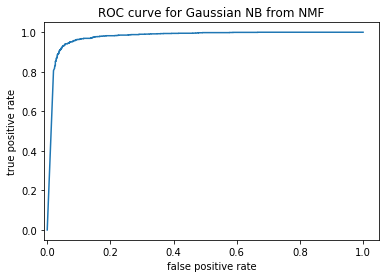

In [25]:
########################################################################################################################
# Generate stats for GaussianNB using NMF for reduction

# Define training and testing data sets
X_train = W_nmf_train_reduced
y_train = twenty_train_binary_labels

X_test = W_nmf_test_reduced
y_test = twenty_test_binary_labels

clf = GaussianNB().fit(X_train, twenty_train_binary_labels)

predicted = clf.predict(X_test)

# Display GNB Stats
print('Accuracy for Gaussian NB for NMF: ', clf.score(X_test, y_test))
print('Average precision-recall score for Gaussian NB for NMF:', average_precision_score(y_test, predicted))
print('Precision score for Gaussian NB for NMF: ', precision_score(y_test, predicted))
print('Recall score for Gaussian NB for NMF: ', recall_score(y_test, predicted))
print('F-1 score for Gaussian NB for NMF:', f1_score(y_test, predicted))

# GNB ROC Curve
prob_score = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, prob_score[:, 1])

plt.figure()
plt.plot(fpr, tpr)
plt.title('ROC curve for Gaussian NB from NMF')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(left=-0.01)
plt.show()

#### Question 7

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD, NMF

# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
# print(__doc__)
cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

pipeline = Pipeline([
    ('import', Importer(remove=None)),
    ('lemm', Lemmatizer(enabled=True)),
    ('vect', CountVectorizer(min_df=1, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD()),
    ('clf', GaussianNB()),
],
memory=memory
)

param_grid = [
    {
        'import__remove': [None, ['headers', 'footers']],
        'lemm__enabled': [False, True],
        'vect__min_df': [3, 5],
        'reduce_dim': [TruncatedSVD(random_state=42, n_components=50), NMF(random_state=42, n_components=50)],
        'clf': [LinearSVC(C=gamma_1,max_iter=100000),
               LogisticRegression(random_state=42, C=0.1, penalty='l1', solver='liblinear'),
               LogisticRegression(random_state=42, C=0.01, penalty='l2', solver='liblinear'),
               GaussianNB()]
    }
]

grid = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, scoring='accuracy')
grid.fit(twenty_train.data, twenty_train_binary_labels)
rmtree(cachedir)

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmpb3scjhdo'", use "location='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmpb3scjhdo'" instead.


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(Importer(remove=None), [ 'From: rschmitt@shearson.com (Robert Schmitt)\n'
  'Subject: Re: Please Recommend 3D Graphics Library F\n'
  'Reply-To: rschmitt@shearson.com\n'
  'Organization: Lehman Brothers, Inc.\n'
  'Lines: 9\n'
  '\n'
  'What hardware do plan to run on?  Workstation or PC?  Cost level?\n'
  'Run-time licensing needs?\n'
  '\n'
  'Bob\n'
  '------------------------------------------------------------------\n'
  'Robert A. Schmitt | Applied Derivatives Technology | Lehman Brothers\n'
  'rschmitt@shearson.com\n'
  '\n'
  '\n',
  'From: mori@volga.mfd.cs.fujitsu.co.jp (Tsuyoshi Mori)\n'
  'Subject: I want use DeskJet on System7\n'
  'Organization: FUJITSU.Ltd., Kawasaki, Japan.\n'
  'Lines: 15\n'
  'Di..., 
array([0., ..., 0.]), None)
________________________________________________fit_transform_one - 0.7s, 0.0min
______

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 3.54s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x17574 sparse matrix of type '<class 'numpy.int64'>'
	with 329115 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x17574 sparse matrix of type '<class 'numpy.float64'>'
	with 329115 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 3.31s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x17232 sparse matrix of type '<class 'numpy.int64'>'
	with 324344 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x17232 sparse matrix of type '<class 'numpy.float64'>'
	with 324344 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 3.39s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x17671 sparse matrix of type '<class 'numpy.int64'>'
	with 328511 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x17671 sparse matrix of type '<class 'numpy.float64'>'
	with 328511 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 3.35s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x17321 sparse matrix of type '<class 'numpy.int64'>'
	with 327753 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3786x17321 sparse matrix of type '<class 'numpy.float64'>'
	with 327753 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 3.49s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3787x17420 sparse matrix of type '<class 'numpy.int64'>'
	with 328453 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3787x17420 sparse matrix of type '<class 'numpy.float64'>'
	with 328453 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.42s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x11007 sparse matrix of type '<class 'numpy.int64'>'
	with 306922 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x11007 sparse matrix of type '<class 'numpy.float64'>'
	with 306922 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.42s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x10930 sparse matrix of type '<class 'numpy.int64'>'
	with 303063 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x10930 sparse matrix of type '<class 'numpy.float64'>'
	with 303063 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.24s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x11017 sparse matrix of type '<class 'numpy.int64'>'
	with 306084 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x11017 sparse matrix of type '<class 'numpy.float64'>'
	with 306084 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.38s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x11109 sparse matrix of type '<class 'numpy.int64'>'
	with 306687 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3786x11109 sparse matrix of type '<class 'numpy.float64'>'
	with 306687 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.35s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3787x11048 sparse matrix of type '<class 'numpy.int64'>'
	with 306977 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3787x11048 sparse matrix of type '<class 'numpy.float64'>'
	with 306977 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
_____________________________________________

________________________________________________fit_transform_one - 9.0s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\bc64d833e6b3db3c1a80e7ac2b1000e8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\82140bd2f442b4c2760965176386c41c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\c2184b5877206ad033578eaeb7ca465c
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_tra

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(Lemmatizer(enabled=True), [ 'From: rschmitt@shearson.com (Robert Schmitt)\n'
  'Subject: Re: Please Recommend 3D Graphics Library F\n'
  'Reply-To: rschmitt@shearson.com\n'
  'Organization: Lehman Brothers, Inc.\n'
  'Lines: 9\n'
  '\n'
  'What hardware do plan to run on?  Workstation or PC?  Cost level?\n'
  'Run-time licensing needs?\n'
  '\n'
  'Bob\n'
  '------------------------------------------------------------------\n'
  'Robert A. Schmitt | Applied Derivatives Technology | Lehman Brothers\n'
  'rschmitt@shearson.com\n'
  '\n'
  '\n',
  'From: mori@volga.mfd.cs.fujitsu.co.jp (Tsuyoshi Mori)\n'
  'Subject: I want use DeskJet on System7\n'
  'Organization: FUJITSU.Ltd., Kawasaki, Japan.\n'
  'Lines: 15\n'
  'Di..., 
array([0., ..., 0.]), None)
______________________________________________fit_transform_one - 234.7s, 3.9min
___

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 3.07s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 4.0s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x15047 sparse matrix of type '<class 'numpy.int64'>'
	with 298635 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x15047 sparse matrix of type '<class 'numpy.float64'>'
	with 298635 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.89s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.9s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x14645 sparse matrix of type '<class 'numpy.int64'>'
	with 293964 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x14645 sparse matrix of type '<class 'numpy.float64'>'
	with 293964 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.94s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 4.0s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x15146 sparse matrix of type '<class 'numpy.int64'>'
	with 298181 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x15146 sparse matrix of type '<class 'numpy.float64'>'
	with 298181 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.89s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 4.0s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x14736 sparse matrix of type '<class 'numpy.int64'>'
	with 297203 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3786x14736 sparse matrix of type '<class 'numpy.float64'>'
	with 297203 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 3.06s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.9s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3787x14933 sparse matrix of type '<class 'numpy.int64'>'
	with 298555 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3787x14933 sparse matrix of type '<class 'numpy.float64'>'
	with 298555 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.08s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.8s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x9261 sparse matrix of type '<class 'numpy.int64'>'
	with 279144 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x9261 sparse matrix of type '<class 'numpy.float64'>'
	with 279144 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.91s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.7s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x9178 sparse matrix of type '<class 'numpy.int64'>'
	with 275518 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x9178 sparse matrix of type '<class 'numpy.float64'>'
	with 275518 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.05s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.8s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x9256 sparse matrix of type '<class 'numpy.int64'>'
	with 278344 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x9256 sparse matrix of type '<class 'numpy.float64'>'
	with 278344 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.10s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.8s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x9359 sparse matrix of type '<class 'numpy.int64'>'
	with 278993 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3786x9359 sparse matrix of type '<class 'numpy.float64'>'
	with 278993 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.17s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.7s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3787x9325 sparse matrix of type '<class 'numpy.int64'>'
	with 279611 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3787x9325 sparse matrix of type '<class 'numpy.float64'>'
	with 279611 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
_______________________________________________

________________________________________________fit_transform_one - 4.9s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\bc64d833e6b3db3c1a80e7ac2b1000e8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\81e4258d5fad4d9e070797f8d4490fbf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\56fb47c3bb6be345d50a53efe14b306b
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_tra

________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(Lemmatizer(enabled=False), [ 'What hardware do plan to run on?  Workstation or PC?  Cost level?\n'
  'Run-time licensing needs?\n'
  '\n'
  'Bob',
  'I used HP DeskJet with Orange Micros Grappler LS on System6.0.5.\n'
  '\n'
  'But now I update system 6.0.5 to System7 with Kanji-Talk 7.1,\n'
  'then I can not print by my DeskJet.\n'
  '\n'
  'Is the Grappler LS old ?\n'
  'Can I use DeskJet on System7 ?\n'
  '\n'
  'Please tell me how to use DeskJet on System7.\n'
  '\n'
  'Thank you\n',
  'Has anyone used the Number Nine (# 9) Video Graphics adaptor with Windows\n'
  'or Windows NT?  What do you think???',
  'I look at zApp and really liked it. However, I think you should\n'
  'wait for version 2.0 (I think it will b..., 
array([0., ..., 0.]), None)
__

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.85s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.4s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x14648 sparse matrix of type '<class 'numpy.int64'>'
	with 241382 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x14648 sparse matrix of type '<class 'numpy.float64'>'
	with 241382 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.79s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x14377 sparse matrix of type '<class 'numpy.int64'>'
	with 237491 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x14377 sparse matrix of type '<class 'numpy.float64'>'
	with 237491 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.89s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.4s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x14870 sparse matrix of type '<class 'numpy.int64'>'
	with 242060 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x14870 sparse matrix of type '<class 'numpy.float64'>'
	with 242060 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.83s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x14540 sparse matrix of type '<class 'numpy.int64'>'
	with 241095 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3786x14540 sparse matrix of type '<class 'numpy.float64'>'
	with 241095 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.99s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3787x14676 sparse matrix of type '<class 'numpy.int64'>'
	with 241604 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3787x14676 sparse matrix of type '<class 'numpy.float64'>'
	with 241604 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.84s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x9052 sparse matrix of type '<class 'numpy.int64'>'
	with 222536 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x9052 sparse matrix of type '<class 'numpy.float64'>'
	with 222536 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.93s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x8964 sparse matrix of type '<class 'numpy.int64'>'
	with 219298 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x8964 sparse matrix of type '<class 'numpy.float64'>'
	with 219298 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.25s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x9146 sparse matrix of type '<class 'numpy.int64'>'
	with 222772 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x9146 sparse matrix of type '<class 'numpy.float64'>'
	with 222772 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.99s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x9181 sparse matrix of type '<class 'numpy.int64'>'
	with 222996 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3786x9181 sparse matrix of type '<class 'numpy.float64'>'
	with 222996 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.86s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3787x9172 sparse matrix of type '<class 'numpy.int64'>'
	with 223059 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3787x9172 sparse matrix of type '<class 'numpy.float64'>'
	with 223059 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
_______________________________________________

________________________________________________fit_transform_one - 7.1s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\31ddf07b6aec35e6ff8b21c16365e5a0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\aa99e391a9ea293fe9e5606c774fb7a5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\d3814fef73b7587228db3c88c700c36d
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_tra

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(Lemmatizer(enabled=True), [ 'What hardware do plan to run on?  Workstation or PC?  Cost level?\n'
  'Run-time licensing needs?\n'
  '\n'
  'Bob',
  'I used HP DeskJet with Orange Micros Grappler LS on System6.0.5.\n'
  '\n'
  'But now I update system 6.0.5 to System7 with Kanji-Talk 7.1,\n'
  'then I can not print by my DeskJet.\n'
  '\n'
  'Is the Grappler LS old ?\n'
  'Can I use DeskJet on System7 ?\n'
  '\n'
  'Please tell me how to use DeskJet on System7.\n'
  '\n'
  'Thank you\n',
  'Has anyone used the Number Nine (# 9) Video Graphics adaptor with Windows\n'
  'or Windows NT?  What do you think???',
  'I look at zApp and really liked it. However, I think you should\n'
  'wait for version 2.0 (I think it will b..., 
array([0., ..., 0.]), None)
______________________________________________fit_transform_one - 189.5s, 3.2min
___

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.42s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.2s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x12274 sparse matrix of type '<class 'numpy.int64'>'
	with 217887 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x12274 sparse matrix of type '<class 'numpy.float64'>'
	with 217887 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.37s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.1s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x11942 sparse matrix of type '<class 'numpy.int64'>'
	with 214037 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x11942 sparse matrix of type '<class 'numpy.float64'>'
	with 214037 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.48s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.3s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x12508 sparse matrix of type '<class 'numpy.int64'>'
	with 218613 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x12508 sparse matrix of type '<class 'numpy.float64'>'
	with 218613 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.25s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.2s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x12115 sparse matrix of type '<class 'numpy.int64'>'
	with 217508 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3786x12115 sparse matrix of type '<class 'numpy.float64'>'
	with 217508 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.58s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.2s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3787x12365 sparse matrix of type '<class 'numpy.int64'>'
	with 218698 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3787x12365 sparse matrix of type '<class 'numpy.float64'>'
	with 218698 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.57s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.1s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x7455 sparse matrix of type '<class 'numpy.int64'>'
	with 201709 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x7455 sparse matrix of type '<class 'numpy.float64'>'
	with 201709 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.67s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x7344 sparse matrix of type '<class 'numpy.int64'>'
	with 198620 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x7344 sparse matrix of type '<class 'numpy.float64'>'
	with 198620 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.59s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.1s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x7516 sparse matrix of type '<class 'numpy.int64'>'
	with 201794 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x7516 sparse matrix of type '<class 'numpy.float64'>'
	with 201794 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.72s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.1s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x7546 sparse matrix of type '<class 'numpy.int64'>'
	with 202089 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3786x7546 sparse matrix of type '<class 'numpy.float64'>'
	with 202089 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.76s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.0s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3787x7603 sparse matrix of type '<class 'numpy.int64'>'
	with 202644 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3787x7603 sparse matrix of type '<class 'numpy.float64'>'
	with 202644 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
_______________________________________________

_______________________________________________fit_transform_one - 11.0s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\31ddf07b6aec35e6ff8b21c16365e5a0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\24d3b627e4bd84ce4ee9874c66ebc3d0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\337e7d4eaa7cc9c376be470098fde456
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_tra

___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.7s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\d7b798b72b0b48a61f5c3843cf8fcd47
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.7s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\138eb4019d84efe5e6d2d4deaad75163
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\499bec3abc0e0a7a4342c2112558a22b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\02b290dccb3325f39b8f06db3c8a09fb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\2f7e4e3c2661e7ed367db9a3890e279b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\ac9ec2dbbaee2a798c5a1dfb0a5f854f
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\1ba87630837e13ff44fffc5cff860023
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.5s, 0.0min
[Memory]0.7s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\b8e2d9bda415986896aba105967e4457
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.7s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\b7d63142df94e915b61cc4ef73b4b229
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\3aa0990cb487d8cb8e038672b786ccf4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\bc64d833e6b3db3c1a80e7ac2b1000e8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\81e4258d5fad4d9e070797f8d4490fbf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\43d27eb80f0919b990489d53d281d4df
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\8c0f8c835bae93720fba5151bf398f4e
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\cc0aff7d16fc01d5e56bcbe0d18ce8e5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\75a5c9ea6458701dcc9310a017230740
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\02b290dccb3325f39b8f06db3c8a09fb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\eed1352d6e39439e597884e7b3ac7430
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\919dc4756a3a16c3baa95ae26da699da
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\5943a80dd4b1daf6c5cbbfc5308a01da
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\284aa86de6a5410398032ff5c045deb8
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\bd78fde2bb195f7d06f6829c6630ec4f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\40c64bbf3f0d2a5e9a6f4c895b25dfd1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\31ddf07b6aec35e6ff8b21c16365e5a0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\5cbb6aeea2c5f45286e965953e43e974
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\6ecf80f92b9f65c5fa74bcd8dc5f336d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\8cb8181463b9f42cbaaccf832a3b6c0e
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\c17e99ebaab4286fc5d8d919782040f1
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\6096b35e689fa4de6d394282bb614a8a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\4fd2c801e8ea4eb4a1972203e15c7b6c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\14caaec420fd3a4a7ff5f5deac98e0c6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\76caf92797bd7ebe3b0b24c8f509b89d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\39bdbe11a60926c09fbfbc8c40fda6b2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\4e2084a41d9cace588d8ba19ae2deea7
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\2a37951d0fc1ea9feafd0ea38299c703
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\6cb380f356f113b276c2fe6290408799
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\9f0ca45f44910956a5c8c7369ef57c52
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\5cbb6aeea2c5f45286e965953e43e974
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\c4816fe37dde329cdbe8377bcb8ea012
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\dde5f0cd18310fd93426aadc2c926419
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\005add5ce59c7750331b2f2913273c4a
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\827fc1d72ee8137d235c0a9c3192f55a
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\0407e0596ddd9bb9087a65c1a826a977
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\b1dd582732317fa38e98214162ba2d95
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\76caf92797bd7ebe3b0b24c8f509b89d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\bc64d833e6b3db3c1a80e7ac2b1000e8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\82140bd2f442b4c2760965176386c41c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\c2184b5877206ad033578eaeb7ca465c
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\95781473cb835f47c345377599a2c923
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.5s, 0.0min
[Memory]0.7s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\c01078d7a583c1fcb0b354d3c2a36f0d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.7s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\e6ddc848fc3b51ecc59584e3d07f8f90
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\02b290dccb3325f39b8f06db3c8a09fb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\eed1352d6e39439e597884e7b3ac7430
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\2ec8322ae1cec1ed7392c3c64b178eac
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\2d6d0af0aa8c507aa026e67269cf251c
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\ba884b43bd5c8671be011e68ba807344
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.7s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\fb8ecc6589c1c7b91528be8cf284e0bd
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.7s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\7c4a4471e61965a01a9cb266ac79a8d7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\bc64d833e6b3db3c1a80e7ac2b1000e8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\499bec3abc0e0a7a4342c2112558a22b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\0b1c0efb200a90e35c90f63dd33f71ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\80309008cf6206cdd1dadcf3ca94ecbb
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\6d1c6c12d3a53ca2806228212e2a8e71
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\fc86b35c26e68becc527517b89a884b7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\025edb0206b420e8c4884bfa2e66aa32
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\eed1352d6e39439e597884e7b3ac7430
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\76caf92797bd7ebe3b0b24c8f509b89d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\39bdbe11a60926c09fbfbc8c40fda6b2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\214a911d0396ed1904181c853641e8e4
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\8db28108706d38ab3b53f6d17cd226e5
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\ce4ea2f51b495c2e1510153574fb81e2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\304391a69b73e02ecac2a99857346e9a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\5cbb6aeea2c5f45286e965953e43e974
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\c4816fe37dde329cdbe8377bcb8ea012
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\d0f97f28861b26f7a68d5d26ee493299
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\b00348d6389ef6510ad1c0c53508c8c8
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\b682fe9012f21c58d2e6568d8ea8a629
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\2f8173925a21370728a31160d14c9413
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\04c2111ec294987c634e8568a8993cd6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\76caf92797bd7ebe3b0b24c8f509b89d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\31ddf07b6aec35e6ff8b21c16365e5a0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\24d3b627e4bd84ce4ee9874c66ebc3d0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\c18fc04390ce58f5e9aeb12ab87d6aff
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\b0b3ea8b819898b2914e1b69b9a254e6
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\b072d092ee3da6ff434cdb33d0334ea4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\52b46d1484c50d62bb6a9120905c9f16
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\c4816fe37dde329cdbe8377bcb8ea012
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\eed1352d6e39439e597884e7b3ac7430
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\2ec8322ae1cec1ed7392c3c64b178eac
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\d92e9ca2ba55f9777244e9b3782e27ea
___________________________________fit_transform_one cache loaded - 0.5s, 0.0min
[Memory]0.7s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\b8e2d9bda415986896aba105967e4457
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\cffdd234ca721a98d9abdb7603e97fc6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\4eeb916fd8db9ee8d64ced8acf727d10
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\bc64d833e6b3db3c1a80e7ac2b1000e8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\499bec3abc0e0a7a4342c2112558a22b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\2c2dbd4c489963c91a680ae0c7fe9176
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\4bce4fe267c6491d9f0e5346c9395f1c
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\85956c7ddaa7a8e7153a739701fb1625
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\f306bc53b6a101f1e0659e5843b0f68d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\fe873fb498fe752d0459eb78856a8be2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\eed1352d6e39439e597884e7b3ac7430
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\3aa0990cb487d8cb8e038672b786ccf4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\f4b46a355af6a2f8cd09fc7e3ceadce8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\33e27c14f0e8d62ee718d8ee80c03803
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\bd78fde2bb195f7d06f6829c6630ec4f
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\6dd3a313956cea78dabf4c5d40e5fb84
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\2deb093431baa49e70f11b6c9d2171e2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\499bec3abc0e0a7a4342c2112558a22b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\c4816fe37dde329cdbe8377bcb8ea012
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\d0f97f28861b26f7a68d5d26ee493299
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\bc4d437cfc9cad575345e96601ec490b
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\6096b35e689fa4de6d394282bb614a8a
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\b344ccd5b87156b2b7a74a1b5c85e75d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\213a57df1abad3f5d359a93cee93267f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\76caf92797bd7ebe3b0b24c8f509b89d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\31ddf07b6aec35e6ff8b21c16365e5a0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\aa99e391a9ea293fe9e5606c774fb7a5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\d3814fef73b7587228db3c88c700c36d
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\8739d29bc0a7e990a5efbe335729474d
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\9cc5f621044853c4407aebacb86dadbc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\28839c029a60e2b9530899eadc4f7265
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\c4816fe37dde329cdbe8377bcb8ea012
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\14caaec420fd3a4a7ff5f5deac98e0c6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\00170bb7d4842da0f05b45a624d3cd80
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\86be9dd9b7a14e4a2be8922d2d9dace5
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\0407e0596ddd9bb9087a65c1a826a977
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\3a423b7872a24f6f36c32dbf0f4487c3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\1177a3f0e0b273b55c881558db6a37ed
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_transform_one\31ddf07b6aec35e6ff8b21c16365e5a0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpb3scjhdo\joblib\sklearn\pipeline\_fit_tra

________________________________________________fit_transform_one - 0.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), 
[ 'From: sac@asdi.saic.com (Steve A. Conroy x6172)\n'
  'Subject: Re: Darrrrrrrrryl\n'
  'Organization: SAIC\n'
  'Lines: 33\n'
  '\n'
  'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> 

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 3.87s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.4s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <4732x20297 sparse matrix of type '<class 'numpy.int64'>'
	with 415953 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<4732x20297 sparse matrix of type '<class 'numpy.float64'>'
	with 415953 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

In [35]:
import pandas as pd
pd.DataFrame(grid.cv_results_)

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.wa

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf,param_import__remove,param_lemm__enabled,param_reduce_dim,param_vect__min_df,params,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,10.858358,0.238052,0.974429,0.979237,"LinearSVC(C=1000, class_weight=None, dual=True...",None,False,"TruncatedSVD(algorithm='randomized', n_compone...",3,"{'import__remove': None, 'vect__min_df': 3, 'r...",...,0.976769,0.977807,0.971459,0.980718,0.979894,0.977819,0.214497,0.010071,0.003487,0.001210
1,8.005714,0.233759,0.972950,0.978128,"LinearSVC(C=1000, class_weight=None, dual=True...",None,False,"TruncatedSVD(algorithm='randomized', n_compone...",5,"{'import__remove': None, 'vect__min_df': 5, 'r...",...,0.975713,0.977015,0.967230,0.979134,0.979894,0.977819,0.663965,0.009756,0.004504,0.000717
2,13.084114,0.310826,0.966188,0.969305,"LinearSVC(C=1000, class_weight=None, dual=True...",None,False,"NMF(alpha=0.0, beta_loss='frobenius', init=Non...",3,"{'import__remove': None, 'vect__min_df': 3, 'r...",...,0.970433,0.968824,0.960888,0.969625,0.974603,0.967520,2.560754,0.008623,0.005374,0.001504
3,9.347399,0.287075,0.966610,0.968935,"LinearSVC(C=1000, class_weight=None, dual=True...",None,False,"NMF(alpha=0.0, beta_loss='frobenius', init=Non...",5,"{'import__remove': None, 'vect__min_df': 5, 'r...",...,0.970433,0.964597,0.960888,0.967512,0.971429,0.969105,2.037154,0.009852,0.003925,0.002882
4,242.288765,58.040699,0.973795,0.978550,"LinearSVC(C=1000, class_weight=None, dual=True...",None,True,"TruncatedSVD(algorithm='randomized', n_compone...",3,"{'import__remove': None, 'vect__min_df': 3, 'r...",...,0.972545,0.976486,0.969345,0.980190,0.980952,0.978611,3.376166,4.157924,0.003964,0.001188
5,9.023857,58.613463,0.974007,0.977441,"LinearSVC(C=1000, class_weight=None, dual=True...",None,True,"TruncatedSVD(algorithm='randomized', n_compone...",5,"{'import__remove': None, 'vect__min_df': 5, 'r...",...,0.974657,0.974901,0.972516,0.978870,0.976720,0.979139,0.429747,3.808943,0.001568,0.001776
6,12.594315,58.129608,0.969569,0.972580,"LinearSVC(C=1000, class_weight=None, dual=True...",None,True,"NMF(alpha=0.0, beta_loss='frobenius', init=Non...",3,"{'import__remove': None, 'vect__min_df': 3, 'r...",...,0.969377,0.972787,0.965116,0.975964,0.974603,0.972010,3.624654,3.702544,0.003008,0.002202
7,8.511879,58.465119,0.968512,0.970784,"LinearSVC(C=1000, class_weight=None, dual=True...",None,True,"NMF(alpha=0.0, beta_loss='frobenius', init=Non...",5,"{'import__remove': None, 'vect__min_df': 5, 'r...",...,0.973601,0.970938,0.958774,0.971738,0.973545,0.970689,1.455032,3.901345,0.005446,0.001677
8,10.616968,0.201471,0.973161,0.976912,"LinearSVC(C=1000, class_weight=None, dual=True...","[headers, footers]",False,"TruncatedSVD(algorithm='randomized', n_compone...",3,"{'import__remove': ['headers', 'footers'], 've...",...,0.974657,0.977279,0.969345,0.976492,0.976720,0.978611,1.042030,0.012847,0.003631,0.001711
9,7.219009,0.199866,0.974007,0.976542,"LinearSVC(C=1000, class_weight=None, dual=True...","[headers, footers]",False,"TruncatedSVD(algorithm='randomized', n_compone...",5,"{'import__remove': ['headers', 'footers'], 've...",...,0.974657,0.975429,0.968288,0.976228,0.980952,0.978875,0.472929,0.010578,0.004698,0.001334


#### Question 8

In [3]:
## Create new multiclass dataset

## Pulled from Question 1
categories = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale', 'soc.religion.christian']

twenty_train = fetch_20newsgroups(subset='train', # choose which subset of the dataset to use; can be 'train', 'test', 'all'
                                  categories=categories, # choose the categories to load; if is `None`, load all categories
                                  shuffle=True,
                                  random_state=42, # set the seed of random number generator when shuffling to make the outcome repeatable across different runs
                                  # remove=['headers'],
                                  )
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

X_train = twenty_train.data
y_train = twenty_train.target

X_test = twenty_test.data
y_test = twenty_test.target

# ## Pulled from Question 2
# lemmatized_training = lemmatize_and_filter(twenty_train.data)
# lemmatized_testing = lemmatize_and_filter(twenty_test.data)

# ## Pulled from Question 3
# svd = TruncatedSVD(n_components=50, random_state=42)
# X_lsi_train_reduced = svd.fit_transform(X_lemmatized_train_tfidf)
# Y_lsi_train_reduced = svd.components_
# print(X_lsi_train_reduced.shape)
# print(svd.components_.shape)

# X_lsi_test_reduced = svd.transform(X_lemmatized_test_tfidf)
# Y_lsi_test_reduced = svd.components_
# print(X_lsi_train_reduced.shape)
# print(svd.components_.shape)

In [15]:
## Naive Bayes Multiclass Classification

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD, NMF

# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
# print(__doc__)
cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

pipeline = Pipeline([
    ('import', Importer(remove=None)),
    ('lemm', Lemmatizer(enabled=True)),
    ('vect', CountVectorizer(min_df=3, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD()),
    ('clf', GaussianNB()),
],
memory=memory
)

pipeline.fit(X_train, y_train)

predicted = pipeline.predict(X_test)

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmp7_14pkwn'", use "location='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmp7_14pkwn'" instead.
C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmp2vv20w8m'", use "location='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmp2vv20w8m'" instead.


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(Importer(remove=None), [ 'From: noye@midway.uchicago.edu (vera shanti noyes)\n'
  "Subject: Re: An agnostic's question\n"
  'Reply-To: noye@midway.uchicago.edu\n'
  'Organization: University of Chicago\n'
  'Lines: 23\n'
  '\n'
  'perhaps you can tell your friend that you feel pressured by his\n'
  "continual discussions of this topic -- surely he doesn't feel you\n"
  'should be _pressured_ into something you feel uncomfortable about\n'
  "(since christianity should be a choice one should make on one's own).\n"
  'please also realize that he is doing this out of friendship -- he\n'
  'probably feels you are missing out on something great, and wants to\n'
  'tell you about it.  but since you know where you can lea..., 
array([3, ..., 1], dtype=int64), None)
________________________________________________fit_transform_one - 0.3s, 0.

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.74s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 1.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <2352x8854 sparse matrix of type '<class 'numpy.int64'>'
	with 174332 stored elements in Compressed Sparse Row format>, 
array([3, ..., 1], dtype=int64), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0), 
<2352x8854 sparse matrix of type '<class 'numpy.float64'>'
	with 174332 stored elements in Compressed Sparse Row format>, 
array([3, ..., 1], dtype=int64), None)
________________________

In [17]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
print('Confusion matrix: \n', confusion_matrix(y_test, predicted))

# Display GNB Stats
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print('Accuracy for Gaussian NB from LSI: ', pipeline.score(X_test, y_test))
# print('Average precision-recall score for Gaussian NB from LSI:', average_precision_score(y_test, predicted))
print('Precision score for Gaussian NB from LSI: ', precision_score(y_test, predicted, average='macro'))
print('Recall score for Gaussian NB from LSI: ', recall_score(y_test, predicted, average='macro'))
print('F-1 score for Gaussian NB from LSI:', f1_score(y_test, predicted, average='macro'))

Confusion matrix: 
 [[105 144 143   0]
 [ 64 159 161   1]
 [ 50  91 247   2]
 [  0   0  32 366]]
Accuracy for Gaussian NB from LSI:  0.5603833865814697
Precision score for Gaussian NB from LSI:  0.5746364854849453
Recall score for Gaussian NB from LSI:  0.5584438697818095
F-1 score for Gaussian NB from LSI: 0.5534975752230288
